In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [0]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [0]:
scouts14 = pd.read_csv('scouts14.csv', low_memory=False)
scouts15 = pd.read_csv('scouts15.csv', low_memory=False)
scouts16 = pd.read_csv('scouts16.csv', low_memory=False)
scouts17 = pd.read_csv('scouts17.csv', low_memory=False)
scouts18 = pd.read_csv('scouts18.csv', low_memory=False)

In [4]:
scouts = pd.concat([scouts14, scouts15, scouts16, scouts17, scouts18])
scouts.drop(scouts.index[scouts['posicao']=='tec'], inplace=True)
scouts.shape

(138156, 28)

In [0]:
def add_target(row, data):
    player = row['atleta_id']
    round = row['rodada']
    year = row['ano']
    
    data = data[data['ano'] == year]
    
    next_score = data[(data['atleta_id'] == player) & (data['rodada'] == round+1)]
    
    if next_score.size:
        if next_score.iloc[0]['participou']:
            return next_score.iloc[0]['pontuacao']

    return np.nan

In [6]:
tqdm.pandas()
scouts['target'] = scouts.progress_apply(lambda row: add_target(row, scouts), axis=1)

In [0]:
total = scouts.copy()

In [8]:
scouts['posicao'].value_counts()

mei    47284
ata    31130
zag    22962
lat    21619
gol    15161
Name: posicao, dtype: int64

In [9]:
scouts.dropna(inplace=True)

scouts['posicao'].value_counts()

mei    15477
ata    10146
lat     6675
zag     6486
gol     3021
Name: posicao, dtype: int64

In [10]:
scouts['ano'].value_counts()

2017    8620
2016    8569
2014    8496
2018    8244
2015    7876
Name: ano, dtype: int64

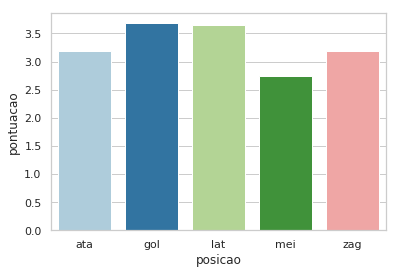

In [11]:
def plot_score_mean(data):
    df = data[(data['participou'])][['pontuacao','posicao']]

    df = df.groupby('posicao').mean()
    
    df.reset_index(inplace=True)
    df.head()
    c = df['posicao'].unique()
    sns.set(style="whitegrid")
    sns.set_palette(sns.color_palette("Paired", n_colors=7))
    ax = sns.barplot(y="pontuacao", x="posicao", data=df)
    
plot_score_mean(scouts)

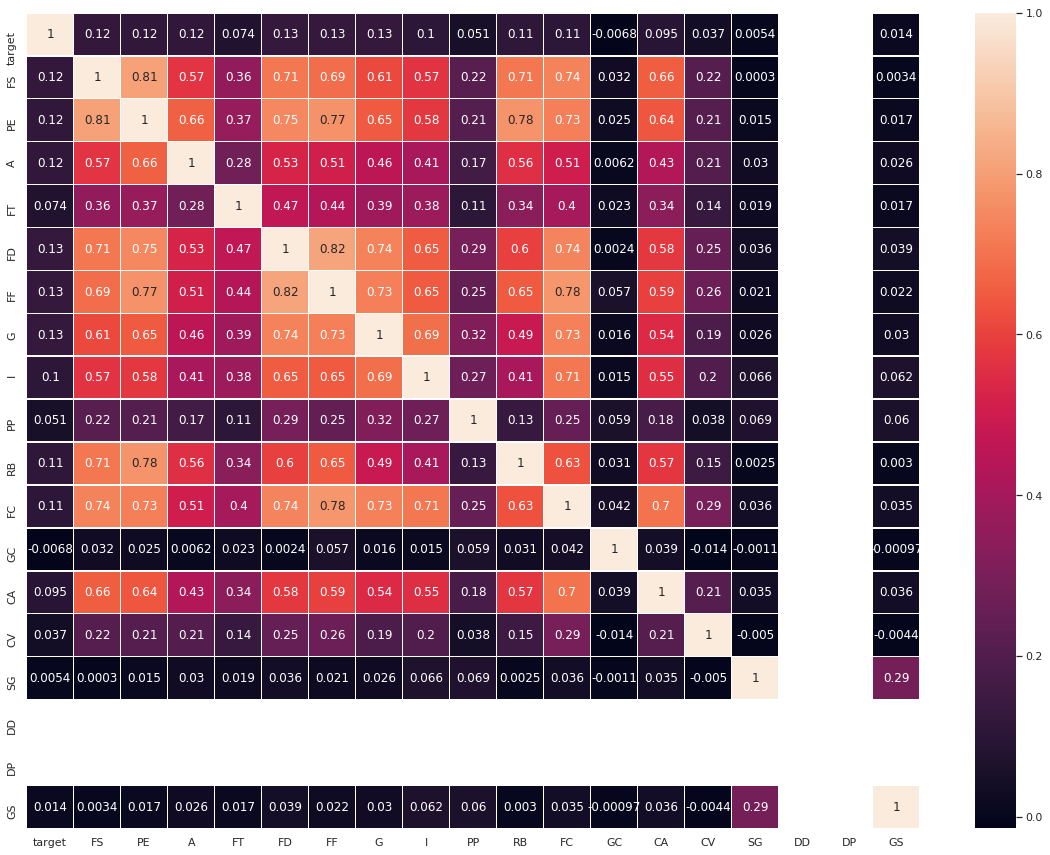

In [12]:
df = scouts[scouts['posicao'] == 'ata']
columns = ['target', 'FS', 'PE', 'A', 'FT', 'FD', 'FF','G', 'I', 'PP', 'RB', 'FC', 'GC', 'CA', 'CV', 'SG', 'DD', 'DP', 'GS']
plt.subplots(figsize=(20,15))
sns.heatmap(df[columns].corr(), annot=True, linewidths=.5)

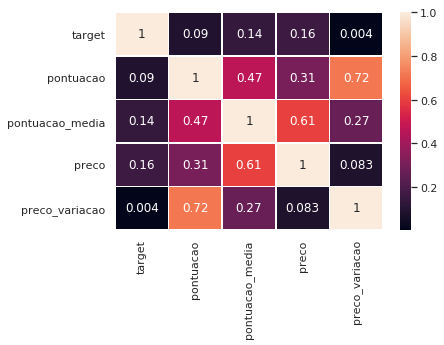

In [13]:
columns = ['target', 'pontuacao', 'pontuacao_media', 'preco', 'preco_variacao', 'posicao']
sns.heatmap(df[columns].corr(), annot=True, linewidths=.5)

## Bloco a ser excluído

#### Jogadores titulares
Esses dados serviram para extrair informações sobre a força da equipe e do adversário.

In [0]:
starting_lineup = {}

for year in total['ano'].unique():
    data = total[total['ano'] == year]
    
    for t in data['clube_id'].unique():
        for r in range(1,39):
            
            team = data[(data['rodada'] == r) & (data['clube_id'] == t)]
            team = team[team['participou']]['atleta_id'].values
            key = str(year) + str(r) + str(t)
            starting_lineup[key] = team

In [0]:
len(starting_lineup)

3800

# Aqui

depende da criação da tr
* diferença de pontos 

* média de gols sofridos
* média de gols feitos
* mandante
* número máximo de jogos sem sofrer gols
* pontos ganhos pelo time na última partida

* pontuação da defesa (titular)
* pontuação do ataque + meio-campo (titular) 
* precisão chute
* precisão defesas
* aproveitamento defesas
* aproveitamento chutes
* média de cada um dos scouts

## Dados dos clubes

A partir das informações sobre as partidas podemos extrair informações úteis para nosso modelo, como: o resultado da última partida de um jogador, a pontuação de sua equipe em uma determinada rodada, etc.

In [0]:
team_dict = pd.read_csv('times_ids.csv')

In [0]:
def get_matchs(year):
    return pd.read_csv(year+'_partidas.csv')

In [0]:
matchs = {year:get_matchs(str(year)) for year in range(2014, 2019)}

In [54]:
matchs[2016].head()

,Unnamed: 0,game,round,date,home_team,score,away_team,arena,X
0,1,1,1,14/05/2016 - 16:00,Palmeiras - SP,4 x 0,Atlético - PR,Allianz Parque - Sao Paulo - SP,NaN
1,2,2,1,14/05/2016 - 16:00,Flamengo - RJ,1 x 0,Sport - PE,Raulino de Oliveira - Volta Redonda - RJ,NaN
2,3,3,1,14/05/2016 - 18:30,Atlético - MG,1 x 0,Santos - SP,Independência - Belo Horizonte - MG,NaN
3,4,4,1,14/05/2016 - 21:00,Coritiba - PR,1 x 0,Cruzeiro - MG,Couto Pereira - Curitiba - PR,NaN
4,5,5,1,15/05/2016 - 11:00,Botafogo - RJ,0 x 1,São Paulo - SP,Raulino de Oliveira - Volta Redonda - RJ,NaN


In [0]:
def replace_slug_by_id(slug):
    name = team_dict[team_dict['nome.cbf'] == slug]['id'].values
    return name[0]

In [0]:
for m in matchs.values():
    m['home_team'] = m.apply(lambda  row: replace_slug_by_id(row['home_team']), axis=1)
    m['away_team'] = m.apply(lambda  row: replace_slug_by_id(row['away_team']), axis=1)

In [59]:
matchs[2016].head()

,Unnamed: 0,game,round,date,home_team,score,away_team,arena,X
0,1,1,1,14/05/2016 - 16:00,275,4 x 0,293,Allianz Parque - Sao Paulo - SP,NaN
1,2,2,1,14/05/2016 - 16:00,262,1 x 0,292,Raulino de Oliveira - Volta Redonda - RJ,NaN
2,3,3,1,14/05/2016 - 18:30,282,1 x 0,277,Independência - Belo Horizonte - MG,NaN
3,4,4,1,14/05/2016 - 21:00,294,1 x 0,283,Couto Pereira - Curitiba - PR,NaN
4,5,5,1,15/05/2016 - 11:00,263,0 x 1,276,Raulino de Oliveira - Volta Redonda - RJ,NaN


### Adversário

In [0]:
def get_opposing_team(row):
    year = row['ano']
    round = row['rodada']
    club = row['clube_id']

    data = matchs[year]
    data = data[(data['round'] == round)]

    data = data[(data['home_team'] == club) | (data['away_team'] == club)].values

    if data.shape[0] == 1:
        return data[0][5] if club == data[0][3] else data[0][3]
    return np.NaN

In [91]:
scouts['oponente'] = scouts.progress_apply(lambda row: get_opposing_team(row), axis=1)

### Cria tabela auxiliar 

In [0]:
tr = pd.DataFrame()

for year in range(2014, 2019):
    
    team_ids = matchs[year]['home_team'].unique()
    data = pd.DataFrame({'team': [], 'round': []})

    for i in range(1, 39):
        df = pd.DataFrame({'team': team_ids,
                           'round': [i] * 20})
        data = data.append(df, sort=False)
    
    data['year'] = year
    
    tr = tr.append(data, sort=False)
    
tr['round'] = tr['round'].astype(int)

In [93]:
tr.head()

,team,round,year
0,262.0,1,2014
1,266.0,1,2014
2,276.0,1,2014
3,277.0,1,2014
4,293.0,1,2014


In [0]:
def is_home_team(team, round, year):
    data = matchs[year]
    is_home = data[(data['home_team'] == team) & 
                   (data['round'] == round)].shape[0]
    return is_home

In [0]:
tr['home_team'] = tr.apply(lambda row: is_home_team(row['team'], row['round'], row['year']), axis=1)

In [0]:
def match_result(team, round, is_home, year):
    
    col = 'home_team' if is_home else 'away_team'
    
    data = matchs[year]
    match = data[(data[col] == team) & 
                 (data['round'] == round)]['score'].values[0]

    if len(match) < 5:
        return 0

    match = match.split('x')

    if int(match[0]) == int(match[1]):
        return 1
    
    if int(match[0]) > int(match[1]):
        if is_home:
            return 3
        return 0

    if int(match[0]) < int(match[1]):
        if is_home:
            return 0
        return 3

In [0]:
tr['result_match'] = tr.apply(lambda row: match_result(row['team'], row['round'], row['home_team'], row['year']), axis=1)

In [111]:
tr.head()

,team,round,year,home_team,result_match
0,262.0,1,2014,1,1
1,266.0,1,2014,1,3
2,276.0,1,2014,1,3
3,277.0,1,2014,1,1
4,293.0,1,2014,1,3


### Pontuação do time a cada rodada

In [0]:
def cs_per_round(row):
    team = row['team']
    round = row['round']
    year = row['year']
    
    data = tr[tr['year'] == year]
    data = data[data['team'] == team]
    data = data[data['round'] <= round]

    score = data['result_match'].sum()

    return score

In [0]:
tr['championship_score'] = tr.apply(lambda row: cs_per_round(row), axis=1)

In [119]:
tr.tail(20).sort_values('championship_score', ascending=False)

,team,round,year,home_team,result_match,championship_score
18,275.0,38,2018,1,3,80
15,262.0,38,2018,1,0,76
9,285.0,38,2018,0,1,69
19,284.0,38,2018,1,3,66
6,276.0,38,2018,0,0,63
10,282.0,38,2018,1,3,59
1,293.0,38,2018,0,3,57
0,283.0,38,2018,0,1,53
7,277.0,38,2018,0,0,50
5,263.0,38,2018,0,0,48


# TODO:
    * Pegar a média de cada scout
    * Pegar a média das coisas do adversário
    

In [0]:
total.groupby(['ano','rodada','clube_id','posicao']).first()
# total.groupby(['ano','clube_id','posicao','rodada']).get_group((2018,285,'ata',10))
# total.head()